In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import pandas as pd
from scipy.integrate import quad_vec
from scipy.special import spherical_jn

from astropy.table import Table

## set fig params|
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\boldmath'],
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline


u.set_enabled_equivalencies(u.mass_energy())

/Users/kpardo/opt/miniconda3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [15]:
exps = ['GDM', 'MAQRO', 'Pino', 'BECCAL']

In [16]:
def plot_exp(ax, exp):
    ## load data
    dat = Table.read(f'../results/limits/{exp}_True_l_5.dat', format='ascii.csv')
    ax.loglog(dat['mx'], dat['sigma'], lw=2, label=f'$\\rm{{{exp}}}$')

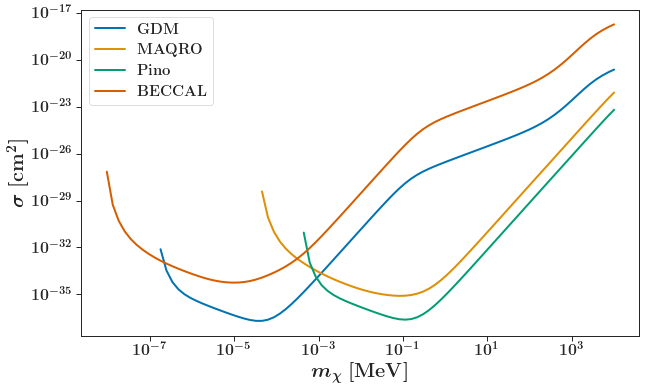

In [17]:
f, ax = plt.subplots(1,1, figsize=(10,6))

for ex in exps:
    plot_exp(ax, ex)

plt.legend(loc='upper left', fontsize=15)
ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
ax.set_ylabel(r'$\sigma~[\rm{cm}^2]$');

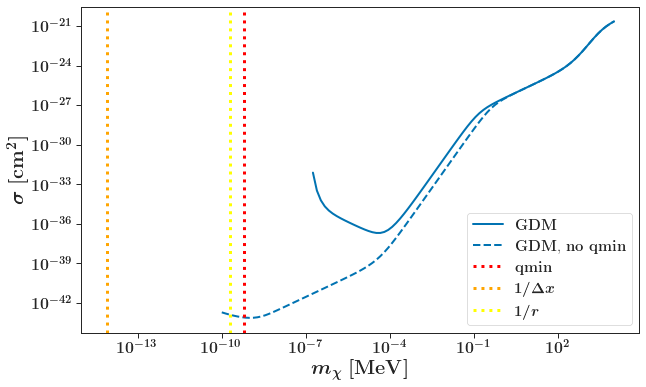

In [9]:
f, ax = plt.subplots(1,1, figsize=(10,6))
plt.loglog(mxs, sigs, lw=2, label=r'$\rm{GDM}$')
plt.loglog(mxs, sigs_noqmin, lw=2, c=cs[0], ls='dashed', label=r'$\rm{GDM}$, $\rm{no~qmin}$')

plt.axvline(gdm.qmin.value, lw=3, c='red',ls='dotted', label=r'$\rm{qmin}$')
plt.axvline(1./gdm.deltax.value, lw=3, c='orange',ls='dotted', label=r'$1/\Delta x$')
plt.axvline(1./gdm.r.value, lw=3, c='yellow', ls='dotted', label=r'$1/r$')

plt.legend(loc='lower right', fontsize=15)
ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
ax.set_ylabel(r'$\sigma~[\rm{cm}^2]$');

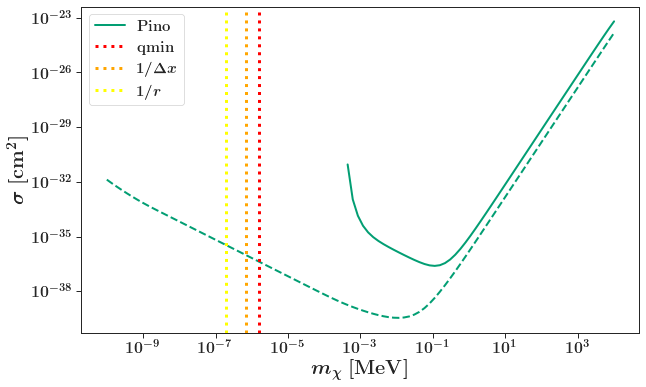

In [10]:
f, ax = plt.subplots(1,1, figsize=(10,6))


plt.loglog(mxs, psigs, lw=2, label=r'$\rm{Pino}$', c=cs[2])
plt.loglog(mxs, psigs_noqmin, lw=2, c=cs[2], ls='dashed')

plt.axvline(pino.qmin.value, lw=3, c='red',ls='dotted', label=r'$\rm{qmin}$')
plt.axvline(1./pino.deltax.value, lw=3, c='orange',ls='dotted', label=r'$1/\Delta x$')
plt.axvline(1./pino.r.value, lw=3, c='yellow', ls='dotted', label=r'$1/r$')

plt.legend(loc='upper left', fontsize=15)
ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
ax.set_ylabel(r'$\sigma~[\rm{cm}^2]$');

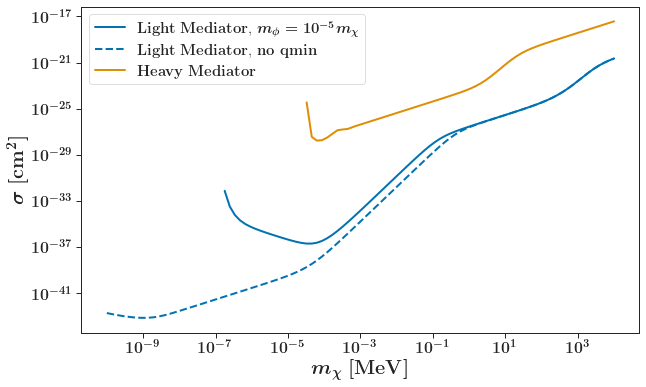

In [11]:
f, ax = plt.subplots(1,1, figsize=(10,6))
plt.loglog(mxs, sigs, lw=2, label=r'$\rm{Light~Mediator}$, $m_{\phi} = 10^{-5}m_{\rm{\chi}}$')
plt.loglog(mxs, sigs_noqmin, lw=2, c=cs[0], ls='dashed', label=r'$\rm{Light~Mediator}$, $\rm{no~qmin}$')
plt.loglog(mxs, sigs_heavy, c=cs[1], lw=2, label=r'$\rm{Heavy~Mediator}$')
plt.legend(loc='upper left', fontsize=15)
ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
ax.set_ylabel(r'$\sigma~[\rm{cm}^2]$');

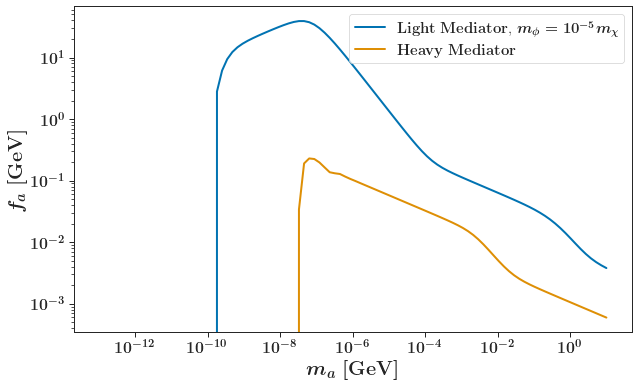

In [12]:
f, ax = plt.subplots(1,1, figsize=(10,6))
plt.loglog(mxs.to(u.GeV), cs_to_axion(sigs), lw=2, label=r'$\rm{Light~Mediator}$, $m_{\phi} = 10^{-5}m_{\rm{\chi}}$')
plt.loglog(mxs.to(u.GeV), cs_to_axion(sigs_heavy), c=cs[1], lw=2, label=r'$\rm{Heavy~Mediator}$')
plt.legend(loc='upper right', fontsize=15)
plt.xlabel(r'$m_{a}~[\rm{GeV}]$');
plt.ylabel(r'$f_a~[\rm{GeV}]$');

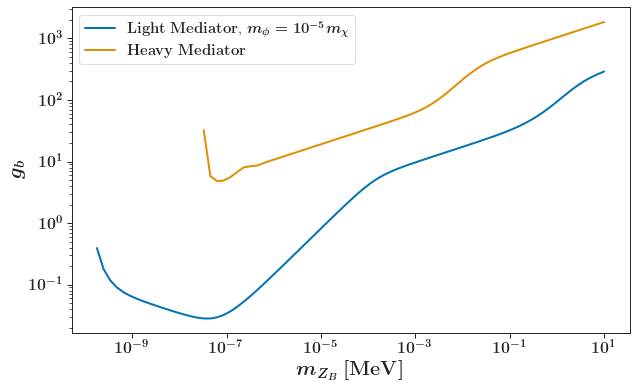

In [13]:
f, ax = plt.subplots(1,1, figsize=(10,6))
plt.loglog(mxs.to(u.GeV), cs_to_gb(sigs), lw=2, label=r'$\rm{Light~Mediator}$, $m_{\phi} = 10^{-5}m_{\rm{\chi}}$')
plt.loglog(mxs.to(u.GeV), cs_to_gb(sigs_heavy), c=cs[1], lw=2, label=r'$\rm{Heavy~Mediator}$')
plt.legend(loc='upper left', fontsize=15)
plt.xlabel(r'$m_{Z_B}~[\rm{MeV}]$');
plt.ylabel(r'$g_b$');

In [14]:
## load 5th force constraints + define conversion to sigma_n
ffmphi, ffyn = np.loadtxt('data/Force5thynVSmPhiGeV.dat', unpack=True)
ffmphi = (ffmphi*u.GeV).to(u.MeV)


def yn_to_sigman(yn, mx, mphi, yx=1, mux=None, vdm=230*u.km/u.s):
    if mux == None:
        mux = mx
    if vdm.unit == u.km/u.s:
        vdm = (vdm/const.c).to('')
    massfac = mux**2/(mphi**2+vdm**2*mx**2)**2
    sig_in_invGeV = (yn**2 * yx**2 * massfac * 1. / (4 * np.pi)).to(1./u.GeV**2)
    return (sig_in_invGeV*1./lp**2).to(u.cm**(2))

In [15]:
ffsigma = yn_to_sigman(ffyn, ffmphi*1.e5, ffmphi)

In [26]:
## load SHe lines
data_dir = 'data/'
HeNRdat = pd.read_csv(data_dir+'NR.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Hephodat = pd.read_csv(data_dir+'phonon2.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')

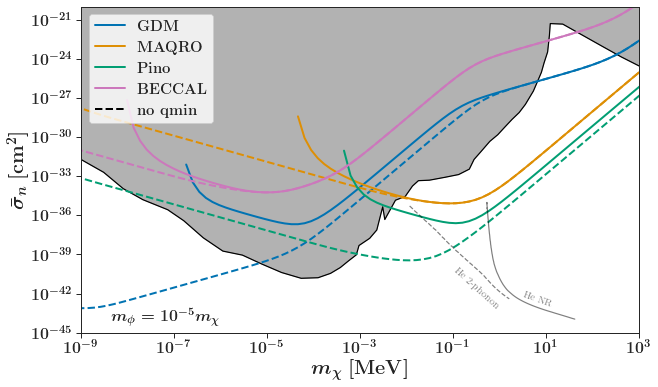

In [38]:
f, ax = plt.subplots(1,1, figsize=(10,6))
plt.loglog(ffmphi*1.e5, ffsigma, color='k')
plt.fill_between(ffmphi*1.e5, ffsigma, 1., color='k', alpha=0.3)
plt.loglog(mxs, sigs, lw=2, label=r'$\rm{GDM}$')
plt.loglog(mxs, sigs_noqmin, lw=2, c=cs[0], ls='dashed')
plt.loglog(mxs, msigs, lw=2, label=r'$\rm{MAQRO}$', c=cs[1])
plt.loglog(mxs, msigs_noqmin, lw=2, c=cs[1], ls='dashed')

plt.loglog(mxs, psigs, lw=2, label=r'$\rm{Pino}$', c=cs[2])
plt.loglog(mxs, psigs_noqmin, lw=2, c=cs[2], ls='dashed')

plt.loglog(mxs, bsigs, lw=2, label=r'$\rm{BECCAL}$', c=cs[4])
plt.loglog(mxs, bsigs_noqmin, lw=2, c=cs[4], ls='dashed')
plt.loglog(mxs, np.ones(len(mxs)), lw=2, c='black', ls='dashed', label=r'$\mathrm{no~qmin}$')

plt.text(0.15, 0.05,r'$m_{\phi} = 10^{-5}m_{\chi}$',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
        fontsize=16)

plt.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
plt.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
plt.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
plt.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

plt.legend(loc='upper left', fontsize=15)
plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
plt.xlim([1.e-9, 1.e3])
plt.ylim([1.e-45, 1.e-20])

plt.savefig('plots/reach_plot.pdf')